## PyRMS test script

simple test script for executing rms from python, for use in the uncertainty pipeline. rms does sensitivities faster


In [1]:
from pyrms import rms
from diffeqpy import de
from julia import Main
import yaml
from julia import Sundials
from diffeqpy import de
import time 
import matplotlib
%matplotlib inline

In [2]:
file_dir = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/baseline/rms/chem53.rms"
# file_dir = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/base/rms/chem27.rms"
# file_dir = "./modified_rms.rms"
# phaseDict = readinput(file_dir); #load mechanism dictionaryb
phase_dict = rms.readinput(file_dir)

In [3]:
expt_condts = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/gua_cantera/all_experiments_reorg_sbr.yaml"

with open(expt_condts, 'r') as file:
    data = yaml.safe_load(file)
# data = yaml.load_file(expt_condts)

# pick just one experiment for example 
conditions = data[2]

# convert volume flow to molar flow
conditions["volume_flowrate"]

FC_temp = 293.15
conditions["molar_flow"] = conditions["volume_flowrate"] * 1.01325e5 / (8.3145 * FC_temp) 

In [4]:
intfc_key = list(phase_dict.keys())[0]
type(intfc_key)

PyCall.jlwrap

In [5]:
gasspcs = phase_dict["gas"]["Species"] # mechanism dictionaries index:  phase_dict[phasename]["Species" or "Reactions"]
gasrxns = phase_dict["gas"]["Reactions"]
surfacespcs = phase_dict["surface"]["Species"]
surfacerxns = phase_dict["surface"]["Reactions"]
interfacerxns = phase_dict[intfc_key]["Reactions"]

In [6]:
type(interfacerxns)

list

In [7]:
ig = rms.IdealGas(gasspcs,gasrxns,name="gas") #Define the phase (how species thermodynamic and kinetic properties calculated)
cat = rms.IdealSurface(surfacespcs, surfacerxns, 2.943e-5, name="surface")

In [8]:
initialcondsgas = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
} #Set simulation Initial Temp and Pressure
# Define the domain (encodes how system thermodynamic properties calculated)
domaingas,y0gas,pgas = rms.ConstantTPDomain(phase=ig,initialconds=initialcondsgas,sensitivity=True)

In [9]:
V = conditions["volume"]
A = conditions["catalyst_area"]
initialconds = {
        "T":conditions["temperature"],
        "A":conditions["catalyst_area"],
        "X":cat.sitedensity*A
} #Set simulation Initial Temp and Pressure
# Define the domain (encodes how system thermodynamic properties calculated)
domaincat,y0cat,pcat = rms.ConstantTAPhiDomain(phase=cat,initialconds=initialconds,sensitivity=True);

## make reactor, inlet and outlet
- makes an anonymous function x->42, is that velocity in? need to check if it is velocity or volume flowrate
- also, I think the ```phi``` refers to chemical potential, but I should check, I think constantTPhi is just const T for our case. 

In [10]:
initialcondsinlet = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
    }

# construct reactor
inter,pinter = rms.ReactiveInternalInterfaceConstantTPhi(domaingas,domaincat,interfacerxns,initialcondsinlet["T"],A);

# make inlet and outlet
inletgas = rms.Inlet(domaingas,initialcondsinlet,Main.eval("x->"+str(conditions["molar_flow"])))
outletgas = rms.Outlet(domaingas,Main.eval("x->"+str(conditions["molar_flow"])))

lets break these apart one by one: 
### ```react,y0,p = Reactor(domains,(y0liq,y0gas),(0.0,tf),interfaces,(pcat,pgas,pinter));```
- react = reactor object, returned from Reactor() function call
- y0 = initial values of all mole fractions, plus last index is... Temperature? 
- p - phases? 

## unconverted  \\|/

In [11]:
# Define domains and interfaces
domains = (domaingas,domaincat)
interfaces = [inter,inletgas,outletgas]

# create a reactor for the system
react,y0,p = rms.Reactor(domains,(y0gas,y0cat),(0.0,100),interfaces,(pgas,pcat,pinter)) # Create the reactor object

In [12]:
t1 = time.time()
sol = de.solve(react.ode,de.CVODE_BDF(),abstol=1e-20,reltol=1e-8)
t2 = time.time()

In [13]:
ssys = rms.SystemSimulation(sol,domains,interfaces,p)

Text(0, 0.5, 'Mole Fraction')

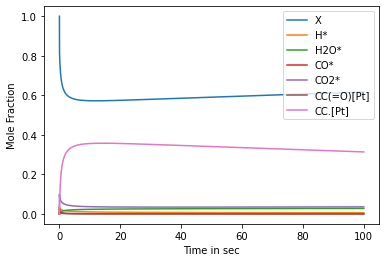

In [14]:
rms.plotmolefractions(ssys.sims[1],tol=0.001)

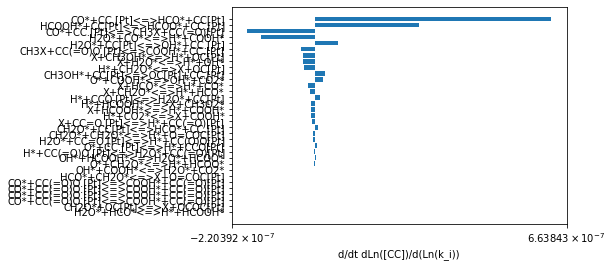

In [15]:
rms.plotrxntransitorysensitivities(ssys, "CC", 100)

we need to extract the reaction objects from julia. the sensitivities are just the second index in the tuple, but the first index is the julia reaction objects. I need to spit out a reaction equation for the spreadsheet. during postprocessing, I need to get the sensitivities and trace them back to their originating family

In [16]:
senss = rms.getrxntransitorysensitivities(ssys, "CC", 100)

PyCall.jlwrap

In [26]:
len(senss)

2

In [28]:
for index, rxn in enumerate(senss[0]): 
    print(rms.getrxnstr(rxn))


CO*+CC.[Pt]<=>HCO*+CC[Pt]
HCOOH*+CC[Pt]<=>HCOO*+CC.[Pt]
CO*+CC.[Pt]<=>CH3X+CC(=O)[Pt]
H2O*+CO*<=>H*+COOH*
H2O*+CC[Pt]<=>OH*+CC.[Pt]
CH3X+CC(=O)O.[Pt]<=>COOH*+CC.[Pt]
X+CH3OH*<=>H*+OC[Pt]
X+H2O*<=>H*+OH*
H*+CH2O*<=>X+OC[Pt]
CH3OH*+CC[Pt]<=>OC[Pt]+CC.[Pt]
O*+COOH*<=>OH*+CO2*
X+HCO*<=>H*+CO*
X+CH2O*<=>H*+HCO*
H*+CCO.[Pt]<=>H2O*+CC[Pt]
H*+HCOOH*<=>X+CH3O2*
X+HCOOH*<=>H*+COOH*
H*+CO2*<=>X+COOH*
X+CC=O.[Pt]<=>H*+CC(=O)[Pt]
CH2O*+CC[Pt]<=>HCO*+CC.[Pt]
CH2O*+CH2O*<=>H*+O=COC[Pt]
H2O*+CC=O.[Pt]<=>H*+CC(O)O[Pt]
O*+CC.[Pt]<=>H*+CCO[Pt]
H*+CC(=O)O.[Pt]<=>H2O*+CC(=O)[Pt]
OH*+HCOOH*<=>H2O*+HCOO*
O*+CH2O*<=>H*+HCOO*
OH*+COOH*<=>H2O*+CO2*
HCO*+CH2O*<=>X+O=COC[Pt]
CO*+CC(=O)O.[Pt]<=>COOH*+CC(=O)[Pt]
CO*+CC(=O)O.[Pt]<=>COOH*+CC(=O)[Pt]
CO*+CC(=O)O.[Pt]<=>COOH*+CC(=O)[Pt]
CO*+CC(=O)O.[Pt]<=>COOH*+CC(=O)[Pt]
CH2O*+OC[Pt]<=>X+OCOC[Pt]
H2O*+HCO*<=>H*+HCOOH*
